TokaMaker Example: Vertical stability in DIII-D from a gEQDSK equilibrium {#doc_tMaker_DIIID_ex2}
==========
In this example we demonstrate:

1) How to reproduce a DIII-D equilibrium using an inverse solve from EFIT by reading in inputs from a gEQDSK file.
2) How to reproduce a DIII-D equilibrium using an forward solve from EFIT by reading in inputs from a gEQDSK file.
3) How to compute linear growth rates and perform time-dependent simulation of a Vertical Displacement Event (VDE) using this equilibrium

This example utilizes the mesh built in \ref doc_tMaker_DIIID_ex1.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, read_eqdsk

## Read equilibrium from gEQDSK file

A dictionary containing the equilibrium information is obtained using \ref OpenFUSIONToolkit.TokaMaker.read_eqdsk "read_eqdsk()".  The dictionary contains multiple key quantities that are useful for reproducing the equilibrium in TokaMaker:
 - eqdsk['rcentr']: The R coordinate of the plasma center
 - eqdsk['bcentr']: The magnetic field at the plasma center
 - eqdsk['ip']: Total plasma current
 - eqdsk['pres']: Pressure profile
 - eqdsk['pprime']: P' profile
 - eqdsk['ffprim']: F*F' profile
 - eqdsk['rzout']: RZ coordinates of the last closed flux surface



In [3]:
eqdsk = read_eqdsk('g192185.02440')

## Compute equilibria

### Initialize TokaMaker object
We create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [4]:
myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   plotting_reorg
Revision id:          454a9f5
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_13936/oftpyin                                                                                                                                      
XML input file        = none                                                                                                                                                                                                    
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Update default settings

Sometimes it is useful to modify the default TokaMaker settings. Here we update one setting to help with convergence:
- `mygs.settings.maxits`: This sets the maximum non-linear iteration count for G-S solver, and should often be increased from the default setting of 40 iterations.

Settings can be modified before running \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" or at any time during execution by adjusting desired values and then calling \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.update_settings "update_settings()".

In [5]:
mygs.settings.maxits = 200

### Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_tMaker_DIIID_ex1 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()", passing the conductor and coil dictionaries for the mesh, to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [6]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('DIIID_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2,F0=eqdsk['rcentr']*eqdsk['bcentr'])


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  1.574E+01
    # of points  =    8910
    # of edges   =   26567
    # of cells   =   17658
    # of boundary points =     160
    # of boundary edges  =     160
    # of boundary cells  =     160
  Resolution statistics:
    hmin =  8.702E-04
    hrms =  4.833E-02
    hmax =  1.540E-01
  Surface grounded at vertex    1733


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    2.2200000000000002E-003


### Define a vertical stability coil
Like many elongated equilibria, the equilibrium we seek to compute below is vertically unstable. In this case we use the `F9A` and `F9B` pair of poloidal field coils for vertical stability in order to help with convergence.

In [7]:
mygs.set_coil_vsc({'F9A': 1.0, 'F9B': -1.0})

## Compute Inverse Equilibrium

### Define global quantities and targets
For the inverse case we define a target for the plasma current and the peak plasma pressure, which occurs on the magnetic axis.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

In [8]:
mygs.set_targets(Ip = eqdsk['ip'], pax=eqdsk['pres'][0])

### Define shape targets
In order to constrain the shape of the plasma we can utilize two types of constraints:
 1. `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS)
 2. `saddle` points, where we want the poloidal magnetic field to vanish (eg. X-points).

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we use the contour defining the last closed flux surface as our `isoflux` constraint, and do not set any `saddle` targets.

In [9]:
isoflux_pts = eqdsk['rzout'].copy()
mygs.set_isoflux(isoflux_pts)

### Define coil regularization matrix

We aim to reproduce the gEQDSK equilibrium from EFIT with equivalent coil currents, so we use the current regularization matrix to constrain the TokaMaker coil currents to be close to the target values.  

In this case, `coil_reg_mat` is an identity matrix with size `mygs.ncoils`+1 that maps each coil to its target current value. `coil_reg_targets` is a vector of length `mygs.ncoils`+1 containing the target current values.  `coil_reg_weights` is a vector of length `mygs.ncoils`+1 which contains values corresponding to how strongly each condition is enforced by the solver.  In this solve, the weights on the `ECOILs` are set high to prevent deviation from the target currents. Additionally, if a given poloidal field coil is found to have significant deviations from the target value, the weight on that coil can be increased, as is done below for `F5A` and `F5B`.


In [10]:
target_currents = {
    'ECOILA': -0.977888676757812/61.0,
    'ECOILB': -0.962711173828125/61.0,
    'F1A': 0.115971984375,
    'F2A': 0.05980789453125,
    'F3A': -0.03076001171875,
    'F4A': -0.0401077421875,
    'F5A': 0.000723009033203125,
    'F6A': -0.1178582578125,
    'F7A': 0.0341264296875,
    'F8A': -0.05660116015625,
    'F9A': 0.236625375,
    'F1B': 0.128368578125,
    'F2B': 0.0763701328125,
    'F3B': -0.02234583203125,
    'F4B': -0.13314096875,
    'F5B': 0.000399709045410156,
    'F6B': -0.15356990625,
    'F7B': 0.0415082109375,
    'F8B': -0.05138975390625,
    'F9B': 0.252380265625
}
for key in target_currents:
    target_currents[key] *= 1.E6

# Set regularization weights
regularization_terms = []
for name, target_current in target_currents.items():
    # Set specific target currents from input equilibrium and different weights depending on the coil set
    if name.startswith('ECOIL'):
        regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=target_current,weight=61.0))
    elif name.startswith('F'):
        if name.startswith('F5'):
            regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=target_current,weight=1.E2))
        else:
            regularization_terms.append(mygs.coil_reg_term({name: 1.0},target=target_current,weight=1.E0))
# Set zero target current and small weight on virtual VSC to allow up-down adjustment
regularization_terms.append(mygs.coil_reg_term({'#VSC': 1.0},target=0.0,weight=1.E-2))

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(reg_terms=regularization_terms)

### Define flux functions
Although TokaMaker has a "default" profile for the F\*F' and P' terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use the P' and F\*F' profiles directly from the gEQDSK we are working to reproduce.

In [11]:
ffprim = eqdsk['ffprim']
pprime = eqdsk['pprime']


psi_eqdsk = np.linspace(0.0,1.0,np.size(ffprim))
psi_sample = np.linspace(0.0,1.0,50)

psi_prof = np.copy(psi_sample)
ffp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,ffprim)))).copy()
pp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,pprime)))).copy()

mygs.set_profiles(ffp_prof={'type': 'linterp', 'y': ffp_prof[:,1], 'x': psi_sample},pp_prof={'type': 'linterp', 'y': pp_prof[:,1], 'x': psi_sample})

### Compute equilibrium
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.init_psi "init_psi()". This subroutine initializes the flux using the specified Ip_target from above, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation and triangularity. Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization. 

\ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve "solve()" is then called to compute a self-consitent Grad-Shafranov equilibrium. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [12]:
R0 = 1.7
Z0 = 0.0
a = 0.5
kappa = 1.3
delta = -0.4

mygs.init_psi(R0, Z0, a, kappa, delta)
mygs.solve()

Starting non-linear GS solver
     1  1.6303E-02 -1.6291E-05  1.3081E-02  1.7588E+00 -5.9053E-02  5.5387E+04
     2 -1.3856E+00 -1.8332E-06  2.2197E-03  1.7612E+00 -5.7513E-02  1.5810E+04
     3 -1.5935E+00 -1.5149E-06  1.2755E-03  1.7648E+00 -5.5110E-02  1.1093E+04
     4 -1.7322E+00 -1.4034E-06  7.9733E-04  1.7683E+00 -5.2593E-02  8.3223E+03
     5 -1.8222E+00 -1.3451E-06  5.1740E-04  1.7711E+00 -5.0289E-02  6.4330E+03
     6 -1.8800E+00 -1.3125E-06  3.5194E-04  1.7733E+00 -4.8246E-02  4.8486E+03
     7 -1.9177E+00 -1.2937E-06  2.5013E-04  1.7750E+00 -4.6461E-02  3.6671E+03
     8 -1.9423E+00 -1.2824E-06  1.9018E-04  1.7763E+00 -4.4913E-02  2.6820E+03
     9 -1.9592E+00 -1.2756E-06  1.4133E-04  1.7772E+00 -4.3572E-02  1.8994E+03
    10 -1.9704E+00 -1.2710E-06  1.1383E-04  1.7779E+00 -4.2415E-02  1.2116E+03
    11 -1.9787E+00 -1.2683E-06  9.1740E-05  1.7785E+00 -4.1420E-02  5.5246E+02
    12 -1.9847E+00 -1.2664E-06  7.6784E-05  1.7788E+00 -4.0566E-02  3.1873E+01
    13 -1.9894E+00 -1.

### Plot equilibrium
Flux surfaces of the computed equilibrium can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi()" method. The additional plotting methods \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_machine "plot_machine()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_constraints "plot_constraints()" are also used to show context and other information. Each method has a large number of optional arguments for formatting and other options.

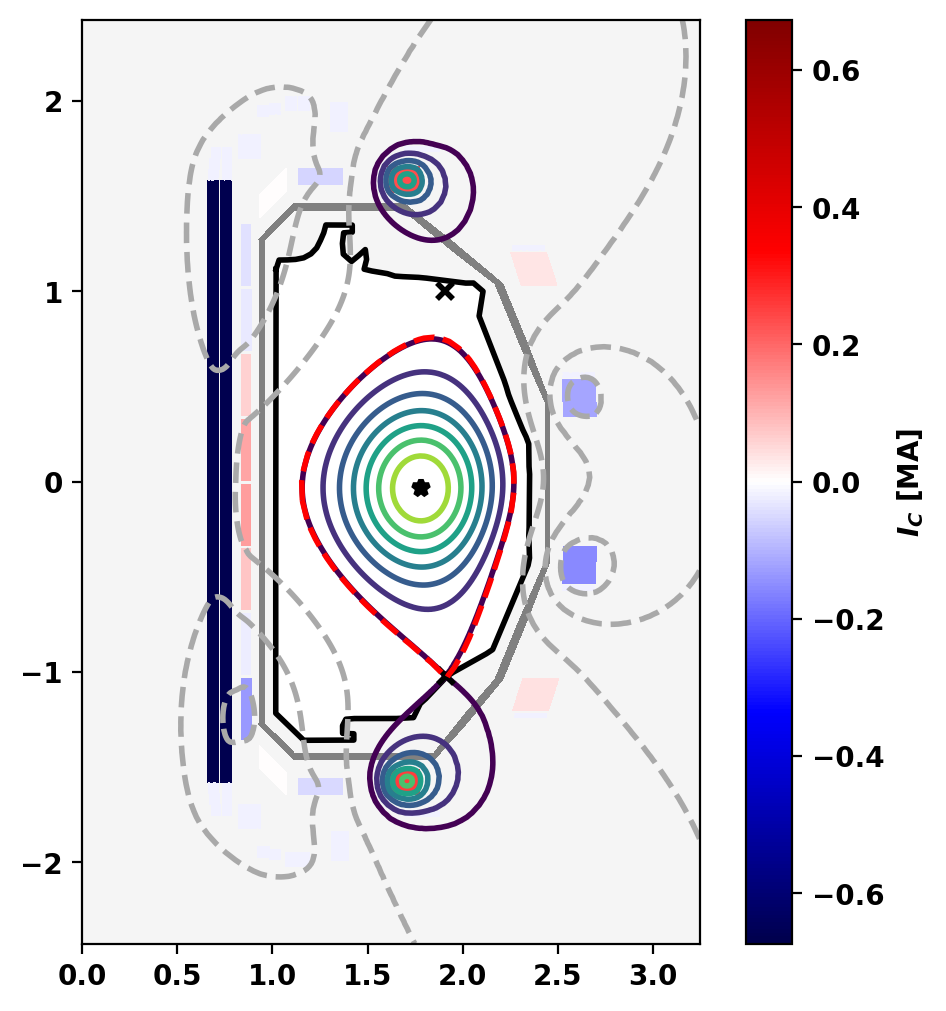

In [13]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,vacuum_nlevels=4)
_ = ax.plot(eqdsk['rzout'][:,0], eqdsk['rzout'][:,1],'r--')

### Print equilibrium information and coil currents
Basic parameters can be displayed using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info()" method. For access to these quantities as variables instead the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_stats "get_stats()" can be used.

The final coil currents can also be retrieved using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_coil_currents "get_coil_currents()" method.  Here, we plot the deviation of the TokaMaker currents from the desired target currents set above.

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    4.9332E+05
  Current Centroid [m]    =    1.758 -0.042
  Magnetic Axis [m]       =    1.780 -0.036
  Elongation              =    1.597 (U:  1.400, L:  1.795)
  Triangularity           =   -0.286 (U: -0.215, L: -0.357)
  Plasma Volume [m^3]     =   14.397
  q_0, q_95               =    0.849  5.386
  Peak Pressure [Pa]      =    6.8216E+03
  Stored Energy [J]       =    3.9480E+04
  <Beta_pol> [%]          =   21.2752
  <Beta_tor> [%]          =    0.1281
  <Beta_n>   [%]          =    0.2703
  Diamagnetic flux [Wb]   =    6.1406E-03
  Toroidal flux [Wb]      =    2.5085E+00
  l_i                     =    1.4981
  F1A:           116.35     115.97       0.33
  F2A:            59.63      59.81       0.30
  F3A:           -31.07     -30.76       1.02
  F4A:           -40.38     -40.11       0.67
  F5A:             0.72       0.72       0.00
  F6A:          -118.52    -117.86       0.56
  F7A:    

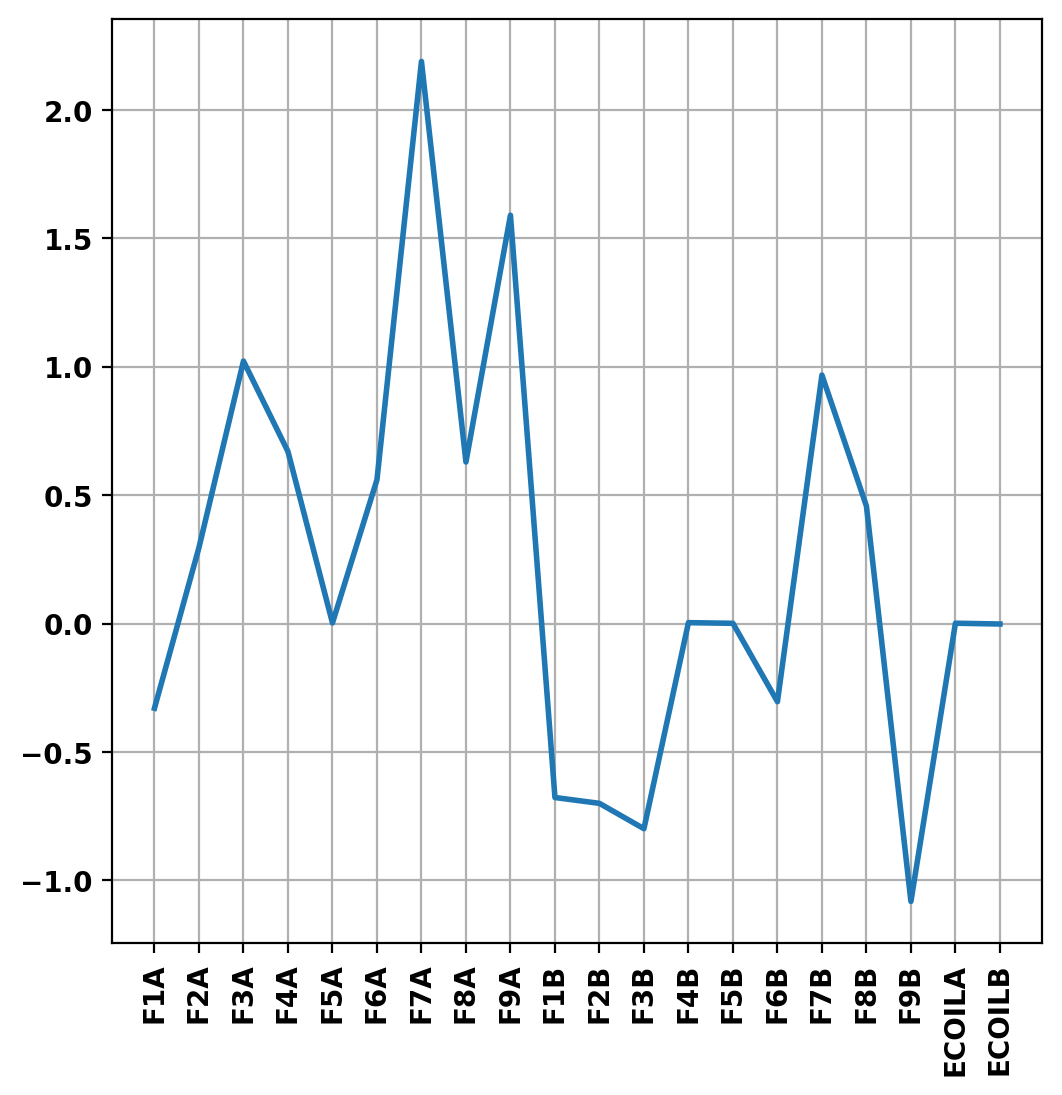

In [14]:
mygs.print_info()

currents, _ = mygs.get_coil_currents()
err = []
keys = []
for key in currents:
    if key.startswith('A') or key.startswith('B'):
        continue
    err.append(100*(target_currents[key]-currents[key])/max(1.E3,abs(target_currents[key])))
    keys.append(key)
    print('  {0:10} {1:10.2F} {2:10.2F} {3:10.2F}'.format(key+":",currents[key]/1.E3,target_currents[key]/1.E3,100*abs((target_currents[key]-currents[key]))/max(1.E3,abs(target_currents[key]))))
plt.plot(range(len(keys)),err)
plt.grid(True)
_ =plt.xticks(range(len(keys)), keys, rotation='vertical')

### Retrieve profile information

Here, we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_profiles "get_profiles()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_q "get_q()"to obtain the profiles of our equilibrium and compare them to the profiles of the target gEQDSK.

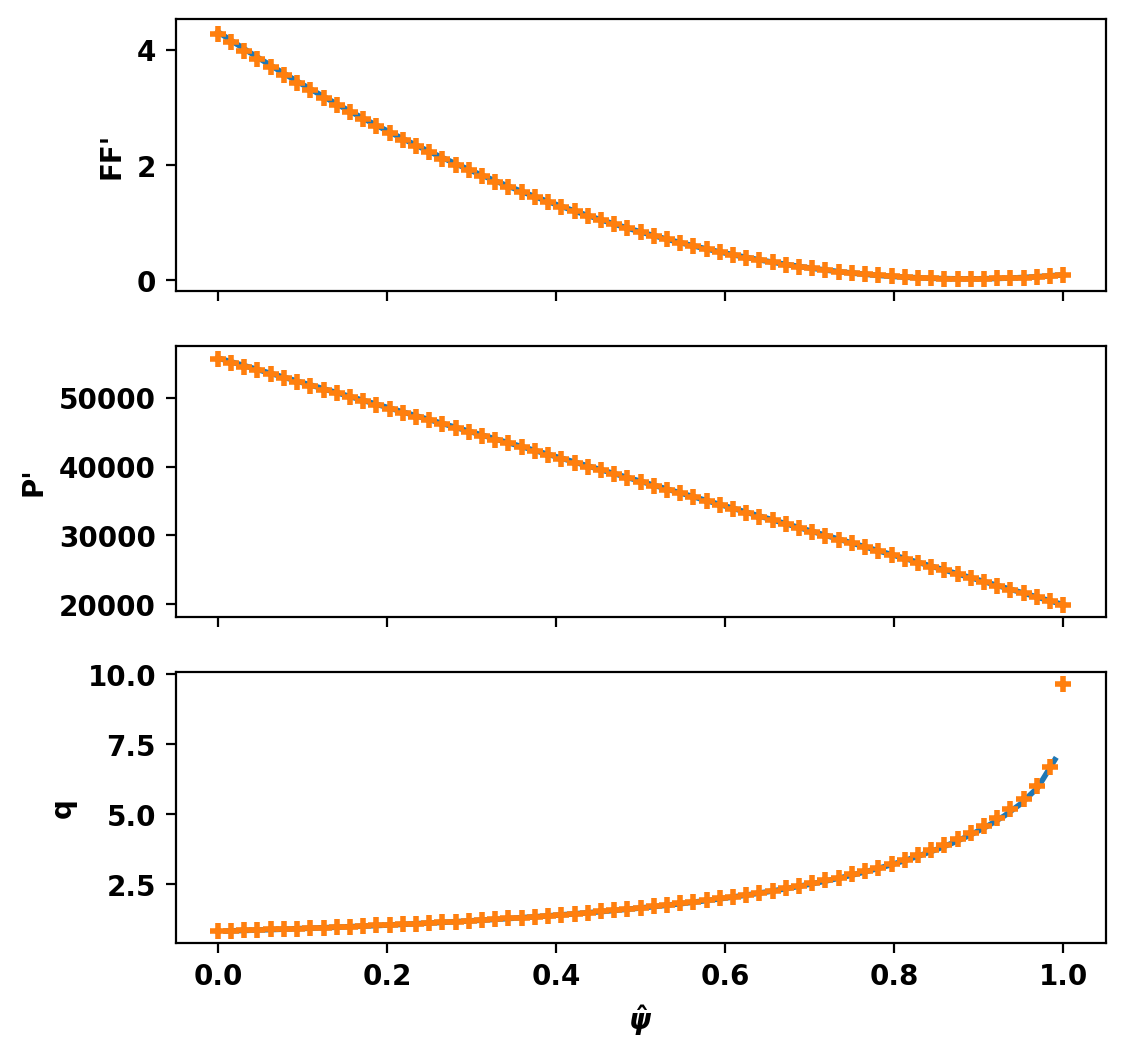

In [15]:
psi,f,fp,p,pp = mygs.get_profiles()
psi_q,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q(psi_pad=0.01)
fig, ax = plt.subplots(3,1,sharex=True)
psi_eqdsk = np.linspace(0.0,1.0,eqdsk['nr'])
psi_sample = np.linspace(0.0,1.0,10)
# Plot F*F'
ax[0].plot(psi,f*fp)
ax[0].plot(psi_eqdsk,-eqdsk['ffprim'],'+')
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(psi,pp)
ax[1].plot(psi_eqdsk,-eqdsk['pprime'],'+')
ax[1].set_ylabel("P'")
# Plot q
ax[2].plot(psi_q,qvals)
ax[2].plot(psi_eqdsk,eqdsk['qpsi'],'+')
ax[2].set_ylabel("q")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

## Compute Forward (Direct) Equilibrium

Instead of using a coil regularization matrix to reach the desired coil currents, the target coil current values can also be set directly using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_currents "set_coil_currents()" method.  For a direct solve such as this, the isoflux and saddle constraints previously imposed should be removed.  We also set new global targets to constrain the axis pressure and vertical position.

In [16]:
mygs.set_isoflux(None)
mygs.set_coil_currents(target_currents)
mygs.set_targets(Ip=eqdsk['ip'],pax=eqdsk['pres'][0],V0=eqdsk['zaxis'])

### Compute equilibrium

In [17]:
mygs.solve()

Starting non-linear GS solver
     1 -2.0137E+00 -1.2595E-06  1.2956E-04  1.7801E+00 -3.5537E-02 -4.7738E+03
     2 -2.0243E+00 -1.2630E-06  4.5152E-04  1.7804E+00 -3.6420E-02 -1.2555E+04
     3 -2.0736E+00 -1.2760E-06  1.5659E-04  1.7810E+00 -3.7484E-02 -8.6298E+03
     4 -2.0814E+00 -1.2580E-06  1.1574E-04  1.7815E+00 -3.8576E-02 -7.7634E+03
     5 -2.0843E+00 -1.2534E-06  1.0200E-04  1.7821E+00 -3.9676E-02 -7.4551E+03
     6 -2.0879E+00 -1.2528E-06  1.0519E-04  1.7825E+00 -4.0779E-02 -7.1880E+03
     7 -2.0916E+00 -1.2524E-06  1.5420E-04  1.7830E+00 -4.2057E-02 -8.4448E+03
     8 -2.1038E+00 -1.2549E-06  6.0032E-04  1.7835E+00 -4.2138E-02  4.2058E+03
     9 -2.0424E+00 -1.2290E-06  2.0731E-04  1.7837E+00 -4.2154E-02 -3.0018E+03
    10 -2.0479E+00 -1.2543E-06  6.3538E-05  1.7839E+00 -4.2157E-02 -2.7746E+03
    11 -2.0500E+00 -1.2556E-06  2.7999E-05  1.7841E+00 -4.2158E-02 -2.5962E+03
    12 -2.0498E+00 -1.2546E-06  2.2575E-05  1.7843E+00 -4.2158E-02 -2.5999E+03
    13 -2.0500E+00 -1.

### Print equilibrium information and coil currents

Here we plot the output of the direct solve, which shows close agreement with the desired plasma boundary.  We also print the equilibrium information and plot the error in the coil currents.  Because the coil currents were set explicitely, there is no deviation between the target and actual currents, except in the vertical stability coil pair.

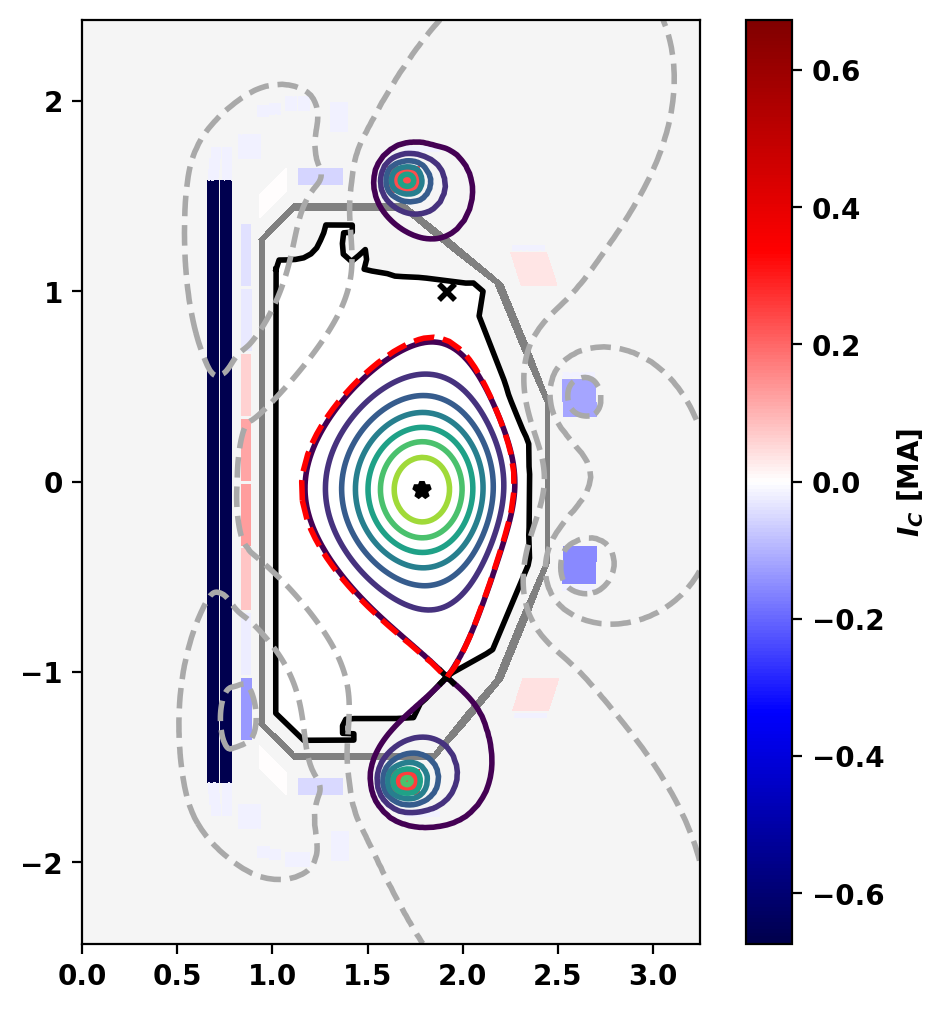

In [18]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,vacuum_nlevels=4)
ax.plot(eqdsk['rzout'][:,0], eqdsk['rzout'][:,1],'r--')

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    4.9332E+05
  Current Centroid [m]    =    1.766 -0.048
  Magnetic Axis [m]       =    1.787 -0.042
  Elongation              =    1.511 (U:  1.396, L:  1.627)
  Triangularity           =   -0.260 (U: -0.202, L: -0.319)
  Plasma Volume [m^3]     =   14.283
  q_0, q_95               =    0.829  5.251
  Peak Pressure [Pa]      =    6.8216E+03
  Stored Energy [J]       =    3.9108E+04
  <Beta_pol> [%]          =   20.9649
  <Beta_tor> [%]          =    0.1294
  <Beta_n>   [%]          =    0.2691
  Diamagnetic flux [Wb]   =    6.1909E-03
  Toroidal flux [Wb]      =    2.4632E+00
  l_i                     =    1.5014
  F1A:           115.97     115.97       0.00
  F2A:            59.81      59.81       0.00
  F3A:           -30.76     -30.76       0.00
  F4A:           -40.11     -40.11       0.00
  F5A:             0.72       0.72       0.00
  F6A:          -117.86    -117.86       0.00
  F7A:     

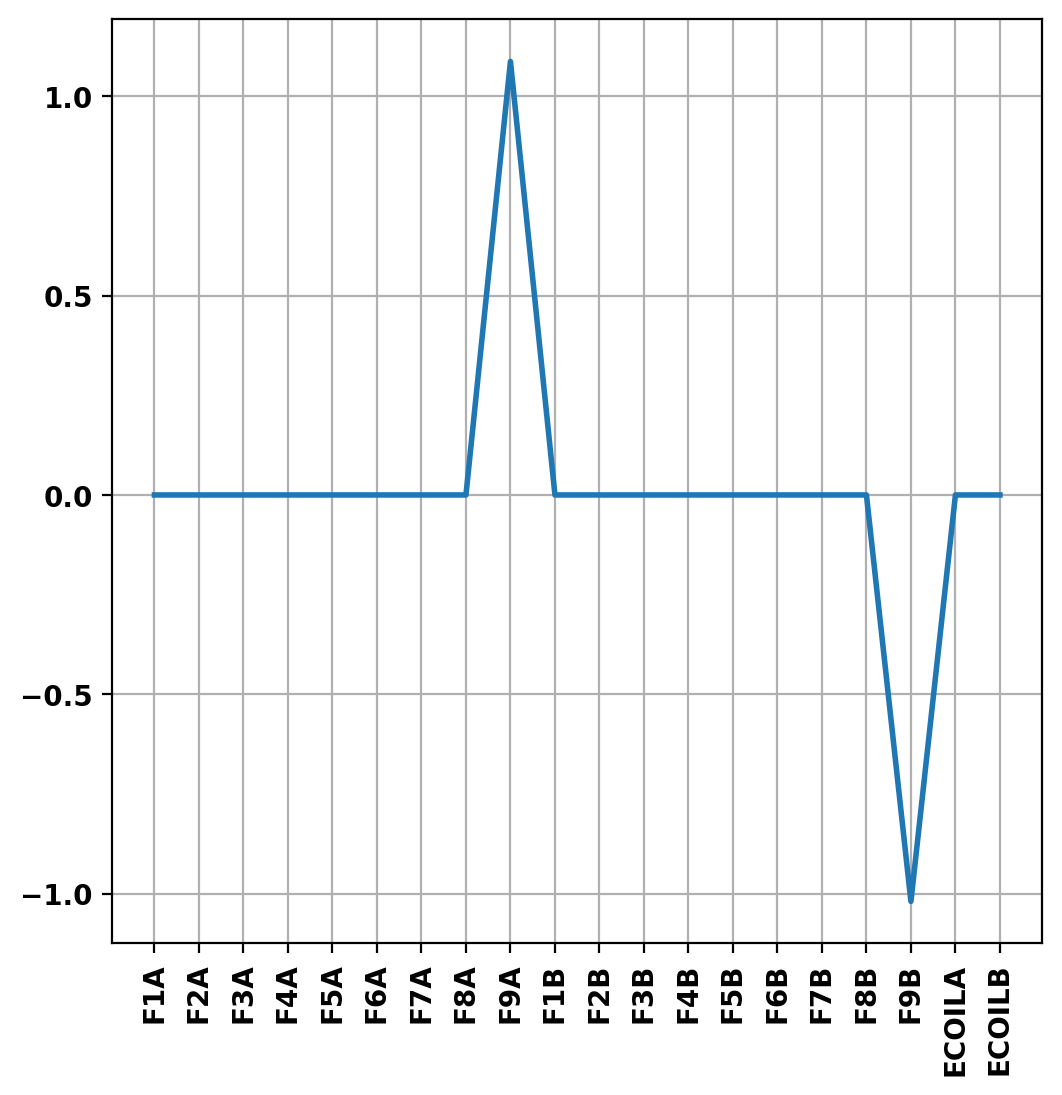

In [19]:
mygs.print_info()

currents, _ = mygs.get_coil_currents()
err = []
keys = []
for key in currents:
    if key.startswith('A') or key.startswith('B'):
        continue
    err.append(100*(target_currents[key]-currents[key])/max(1.E3,abs(target_currents[key])))
    keys.append(key)
    print('  {0:10} {1:10.2F} {2:10.2F} {3:10.2F}'.format(key+":",currents[key]/1.E3,target_currents[key]/1.E3,100*abs((target_currents[key]-currents[key]))/max(1.E3,abs(target_currents[key]))))
plt.plot(range(len(keys)),err)
plt.grid(True)
_ =plt.xticks(range(len(keys)), keys, rotation='vertical')

### Save equilibrium as a gEQDSK file

We save our TokaMaker equilibrium as a gEQDSK file using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.save_eqdsk "save_eqdsk()" method.  We modify the resolution of the equilibrium file by increasing the `nr` and `nz` parameters and decreasing the padding on the last closed flux surface (`lcfs_pad`).


In [20]:
mygs.save_eqdsk('g192185_tokamaker', nr = 200, nz = 200, lcfs_pad = 0.001)

Saving EQDSK file: g192185_tokamaker


## Update equilibrium for linear stability

As is often the case with experimental equilibrium reconstructions, the profiles provided in the gEQDSK file have unrealistically high edge current ($ F*F' $ and $ P' $ at the LCFS). To improve the behavior of the equilibrium during stability and time-dependent solves we apply a simple linear ramp to drop both $ F*F' $ and $ P' $ to zero at $ \hat{\psi} = 1 $.

**Warning:** Even when matching global quantities, this change will modify the stability and time-dependent properties of the equilibrium. Therefore care should always be taken with such a modification to avoid trading on unphysical profile for another.

Additionally, we change the form of our targets to use `Ip_ratio` instead of `pax`. This form allows us to later perform a VDE simulation with constant $ I_p $ and roughly constant $ \beta_p $.

We then recompute the equilibrium to prepare for time-dependent analysis.

In [21]:
# Modify profiles to remove edge current
edge_ramp = (1.0-ffp_prof[:,0])/(0.05)
edge_ramp[edge_ramp > 1.0] = 1.0
mygs.set_profiles(ffp_prof={'type': 'linterp', 'y': edge_ramp*ffp_prof[:,1], 'x': ffp_prof[:,0]},
                  pp_prof={'type': 'linterp', 'y': edge_ramp*pp_prof[:,1], 'x': pp_prof[:,0]})
# Update global targets
mygs.set_targets(Ip=eqdsk['ip'],Ip_ratio=5.6,V0=eqdsk['zaxis'])
# Recompute equilibrim
mygs.solve()

Starting non-linear GS solver
     1 -2.0641E+00 -1.3630E-06  1.6090E-04  1.7878E+00 -4.2159E-02 -4.0962E+03
     2 -2.0459E+00 -1.3506E-06  6.6897E-05  1.7881E+00 -4.2159E-02 -4.3025E+03
     3 -2.0373E+00 -1.3471E-06  3.5098E-05  1.7883E+00 -4.2159E-02 -4.3272E+03
     4 -2.0332E+00 -1.3458E-06  2.1819E-05  1.7885E+00 -4.2159E-02 -4.3284E+03
     5 -2.0314E+00 -1.3453E-06  1.6475E-05  1.7887E+00 -4.2159E-02 -4.3270E+03
     6 -2.0306E+00 -1.3450E-06  1.4258E-05  1.7889E+00 -4.2159E-02 -4.3261E+03
     7 -2.0304E+00 -1.3449E-06  1.3049E-05  1.7890E+00 -4.2159E-02 -4.3255E+03
     8 -2.0304E+00 -1.3448E-06  1.2141E-05  1.7892E+00 -4.2159E-02 -4.3253E+03
     9 -2.0305E+00 -1.3447E-06  1.1339E-05  1.7893E+00 -4.2159E-02 -4.3254E+03
    10 -2.0307E+00 -1.3446E-06  1.0597E-05  1.7894E+00 -4.2159E-02 -4.3255E+03
    11 -2.0309E+00 -1.3446E-06  9.9013E-06  1.7896E+00 -4.2159E-02 -4.3256E+03
    12 -2.0311E+00 -1.3445E-06  9.2487E-06  1.7897E+00 -4.2159E-02 -4.3257E+03
    13 -2.0313E+00 -1.

### Plot profile information
Again we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_profiles "get_profiles()" to compare the updated profiles with the initial gEQDSK profiles and visualize the local modifications introduced at the edge.

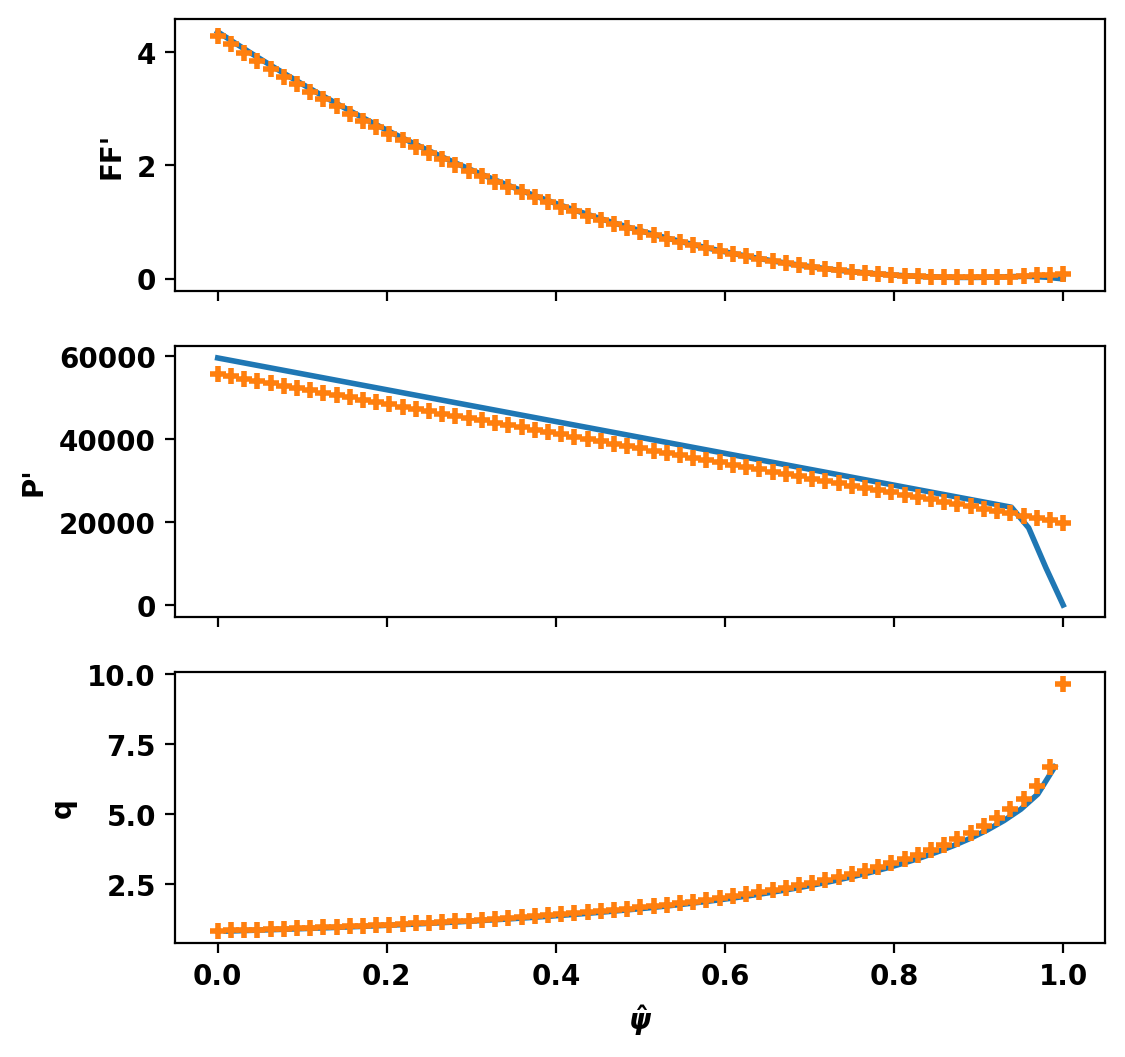

In [22]:
psi,f,fp,p,pp = mygs.get_profiles()
psi_q,qvals,ravgs,dl,rbounds,zbounds = mygs.get_q(psi_pad=0.01)
fig, ax = plt.subplots(3,1,sharex=True)
psi_eqdsk = np.linspace(0.0,1.0,eqdsk['nr'])
psi_sample = np.linspace(0.0,1.0,10)
# Plot F*F'
ax[0].plot(psi,f*fp)
ax[0].plot(psi_eqdsk,-eqdsk['ffprim'],'+')
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(psi,pp)
ax[1].plot(psi_eqdsk,-eqdsk['pprime'],'+')
ax[1].set_ylabel("P'")
# Plot q
ax[2].plot(psi_q,qvals)
ax[2].plot(psi_eqdsk,eqdsk['qpsi'],'+')
ax[2].set_ylabel("q")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

## Linear Stability Analysis

We can compute the most unstable eigenmodes of the linearized system along with their eigenvalues, or growth rates, using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.eig_td "eig_td()" method.  In this case, the most unstable mode corresponds to vertical instability, and has a growth rate of ~807 s^-1.

We also plot the vertically unstable mode and the eddy currents in conducting structures using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_eddy "plot_eddy()" method.

Growth rate = 9.4598E+02 [s^-1]
Growth time = 1.0571E-03 [s]


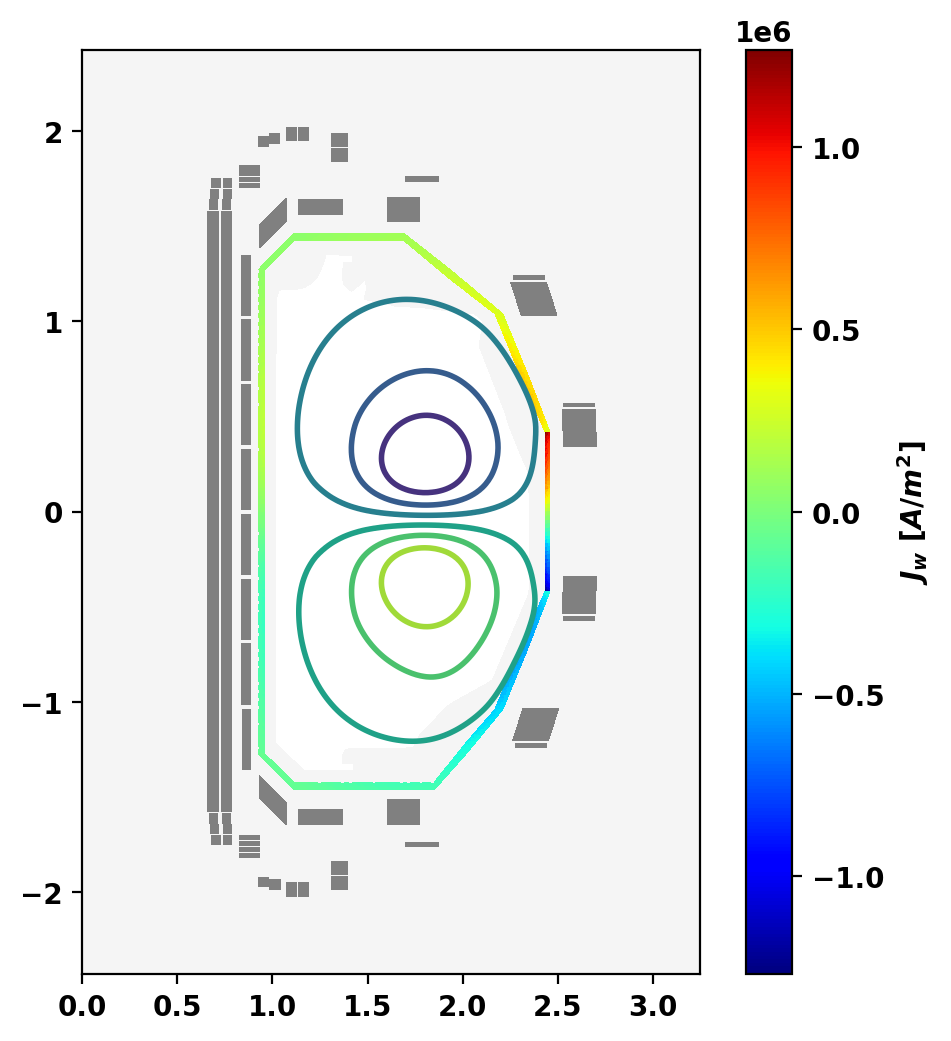

In [23]:
eig_vals, eig_vecs = mygs.eig_td(-5.E3,10,False) 
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,eig_vecs[0,:],normalized=False,xpoint_color=None,opoint_color=None)
mygs.plot_eddy(fig,ax,dpsi_dt=eig_vecs[0,:]*abs(eig_vals[0,0]))
print('Growth rate = {0:.4E} [s^-1]'.format(-eig_vals[0,0]))
print('Growth time = {0:.4E} [s]'.format(-1.0/eig_vals[0,0]))

## Time-dependent VDE simulation
A VDE can be initiated by extracting the original equilibrium $\psi$ using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_psi "get_psi()" and adding a perturbation corresponding to the vertically unstable eigenmode.  Then, \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_psi "set_psi()" can be used to set this modified equilibrium as the initial condition for the time dependent simulation.  The modified equilibrium is visualized below.


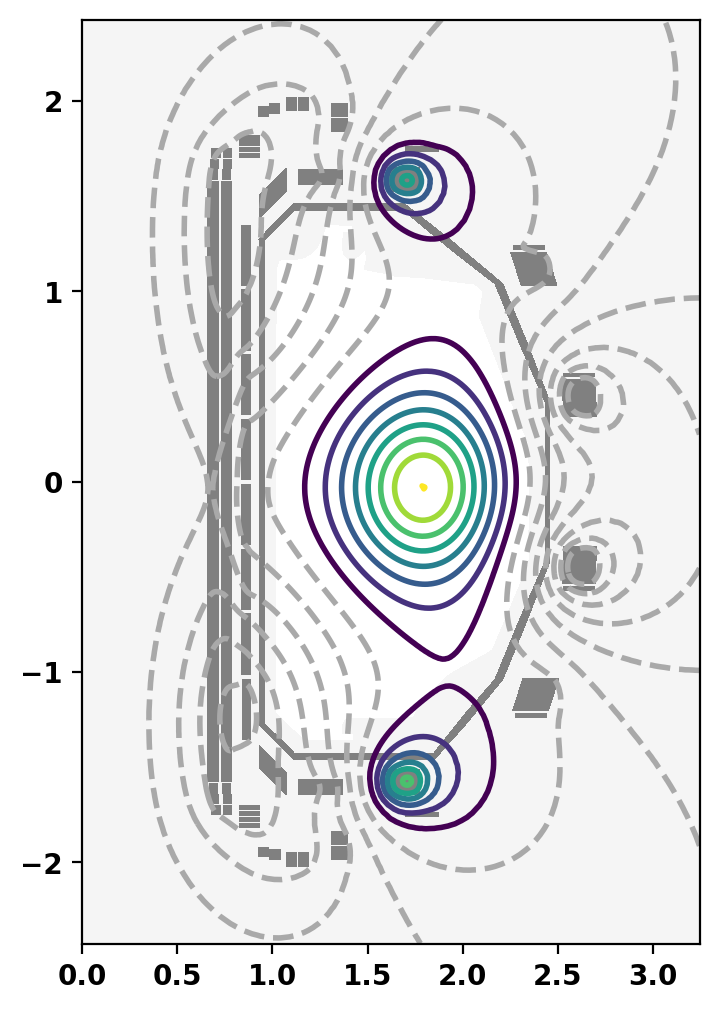

In [24]:
psi0 = mygs.get_psi(normalized = False)
max_loc = abs(eig_vecs[0,:]).argmax()
psi_ic = psi0-eig_vecs[0,:]*(mygs.psi_bounds[1]-mygs.psi_bounds[0])/eig_vecs[0,max_loc]/50.0

fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,(psi_ic-mygs.psi_bounds[1])/(mygs.psi_bounds[0]-mygs.psi_bounds[1]),xpoint_color=None,opoint_color=None)
mygs.set_psi(psi_ic)

### Setup simulation
In order to run the time-dependent simulation, the isoflux constraints are removed and the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_td "setup_td()" method is run to set the initial timestep and tolerances for the solver. A timestep is chosen that aligns with the predicted growth time of the unstable mode.

In [25]:
mygs.settings.pm=False
mygs.update_settings()
mygs.set_isoflux(None)
mygs.set_targets(Ip=eqdsk['ip'],Ip_ratio=5.6)
mygs.setup_td(1.E-03,1.E-13,1.E-11,pre_plasma=False)

### Perform time-dependent simulation
To run the simulation, \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.step_td "step_td()" is run for the desired number of timesteps. At each timestep, we save $\psi$ as well as the vertical position of the magnetic axis and the amplitude of the vertically unstable eigenmode. 

In [26]:
import time
sim_time = 0.0
dt = 1.E-1/-eig_vals[0,0]
nplot = 1
nstatus = 2
results = [mygs.get_psi()]
results_raw = [mygs.get_psi(False)]
z0 = [[sim_time,mygs.o_point[1]],]
eig_comp = [[sim_time,np.dot(eig_vecs[0,:],mygs.get_psi(normalized=False)-psi0)],]
t00 = time.perf_counter()

for i in range(40):
    t0 = time.perf_counter()
    sim_time, _, nl_its, lin_its, nretry = mygs.step_td(sim_time,dt)
    t1 = time.perf_counter()
    if i % nstatus == 0:
        print('{0:.5E} {1:.5E} {2:4d} {3:4d} {5:8.3f} {4:4d}'.format(sim_time,dt,nl_its,lin_its,nretry,t1-t0))
    z0.append([sim_time,mygs.o_point[1]])
    eig_comp.append([sim_time,np.dot(eig_vecs[0,:],mygs.get_psi(normalized=False)-psi0)])
    if i % nplot == 0:
        results.append(mygs.get_psi())
        results_raw.append(mygs.get_psi(False))
t1 = time.perf_counter()
print('Total time = {0:8.3f}'.format(t1-t00))

1.05711E-04 1.05711E-04    2   16    0.287    0
3.17132E-04 1.05711E-04    2   15    0.156    0
5.28554E-04 1.05711E-04    2   16    0.164    0
7.39976E-04 1.05711E-04    2   16    0.165    0
9.51397E-04 1.05711E-04    2   16    0.168    0
1.16282E-03 1.05711E-04    2   17    0.175    0
1.37424E-03 1.05711E-04    2   18    0.181    0
1.58566E-03 1.05711E-04    2   18    0.182    0
1.79708E-03 1.05711E-04    2   18    0.182    0
2.00851E-03 1.05711E-04    2   18    0.182    0
2.21993E-03 1.05711E-04    2   18    0.182    0
2.43135E-03 1.05711E-04    2   18    0.182    0
2.64277E-03 1.05711E-04    2   18    0.188    0
2.85419E-03 1.05711E-04    3   25    0.257    0
3.06561E-03 1.05711E-04    2   19    0.191    0
3.27704E-03 1.05711E-04    2   19    0.192    0
3.48846E-03 1.05711E-04    2   19    0.191    0
3.69988E-03 1.05711E-04    2   19    0.194    0
3.91130E-03 1.05711E-04    2   19    0.192    0
4.12272E-03 1.05711E-04    3   27    0.261    0
Total time =    7.732


### Plot evolution of flux surfaces
We plot the last closed flux surface at each timestep to visualize the plasma evolution.

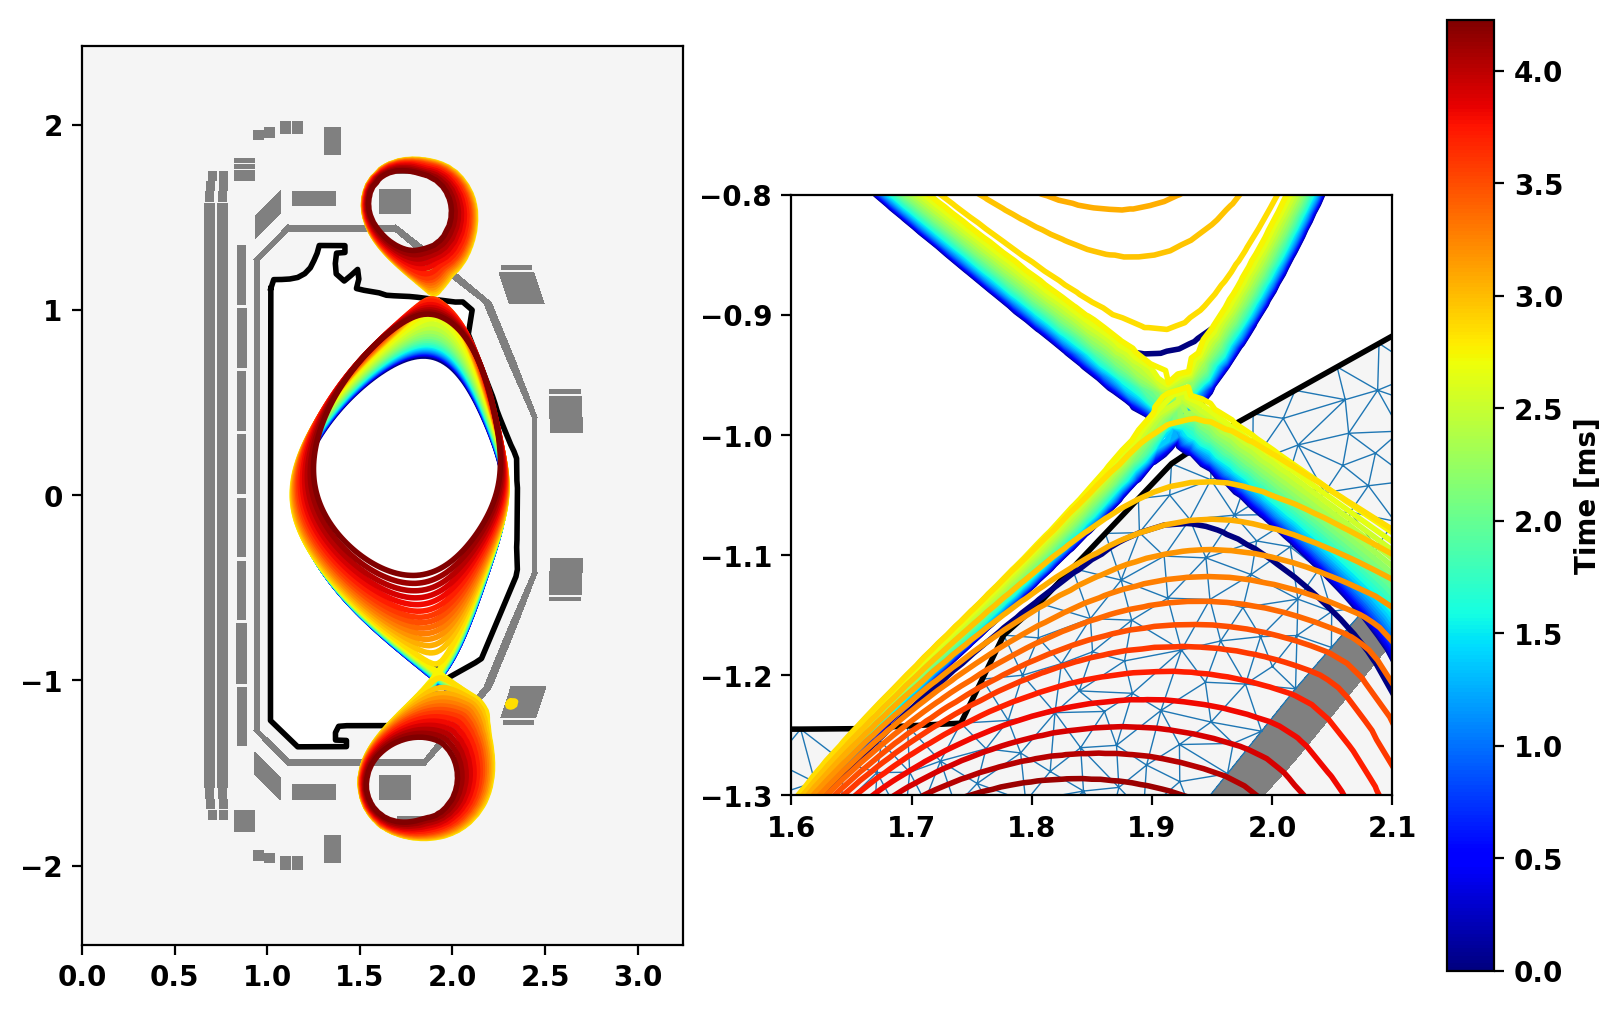

In [27]:
import matplotlib as mpl
fig, ax = plt.subplots(1,2,constrained_layout=True,figsize=(8,5))
mygs.plot_machine(fig,ax[0])
colors = plt.cm.jet(np.linspace(0,1,len(results)))
for i, result in enumerate(results):
    mygs.plot_psi(fig,ax[0],psi=result,plasma_nlevels=1,plasma_color=[colors[i]], vacuum_nlevels = 0,xpoint_color=None,opoint_color=None)
norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time*1.E3)
mygs.plot_machine(fig,ax[1])
colors = plt.cm.jet(np.linspace(0,1,len(results)))
for i, result in enumerate(results):
    mygs.plot_psi(fig,ax[1],psi=result,plasma_nlevels=1,plasma_color=[colors[i]], vacuum_nlevels = 0,xpoint_color=None,opoint_color=None)
ax[1].plot(mygs.lim_point[0],mygs.lim_point[1],'ro')
ax[1].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==3,:],lw=0.5,label=key)
norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time*1.E3)
_ = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet),ax=ax[1],label='Time [ms]')
ax[1].set_ylim(-1.3,-0.8)
_ =ax[1].set_xlim(1.6,2.1)

### Plot time-evolution of equilibrium
Here we plot the evolution of the vertical position of the plasma and the amplitude of the computed eigenvector from above in the solution (as compared to the initial state). Both of these values should grow linearly at the predicted growth rate (shown in orange).

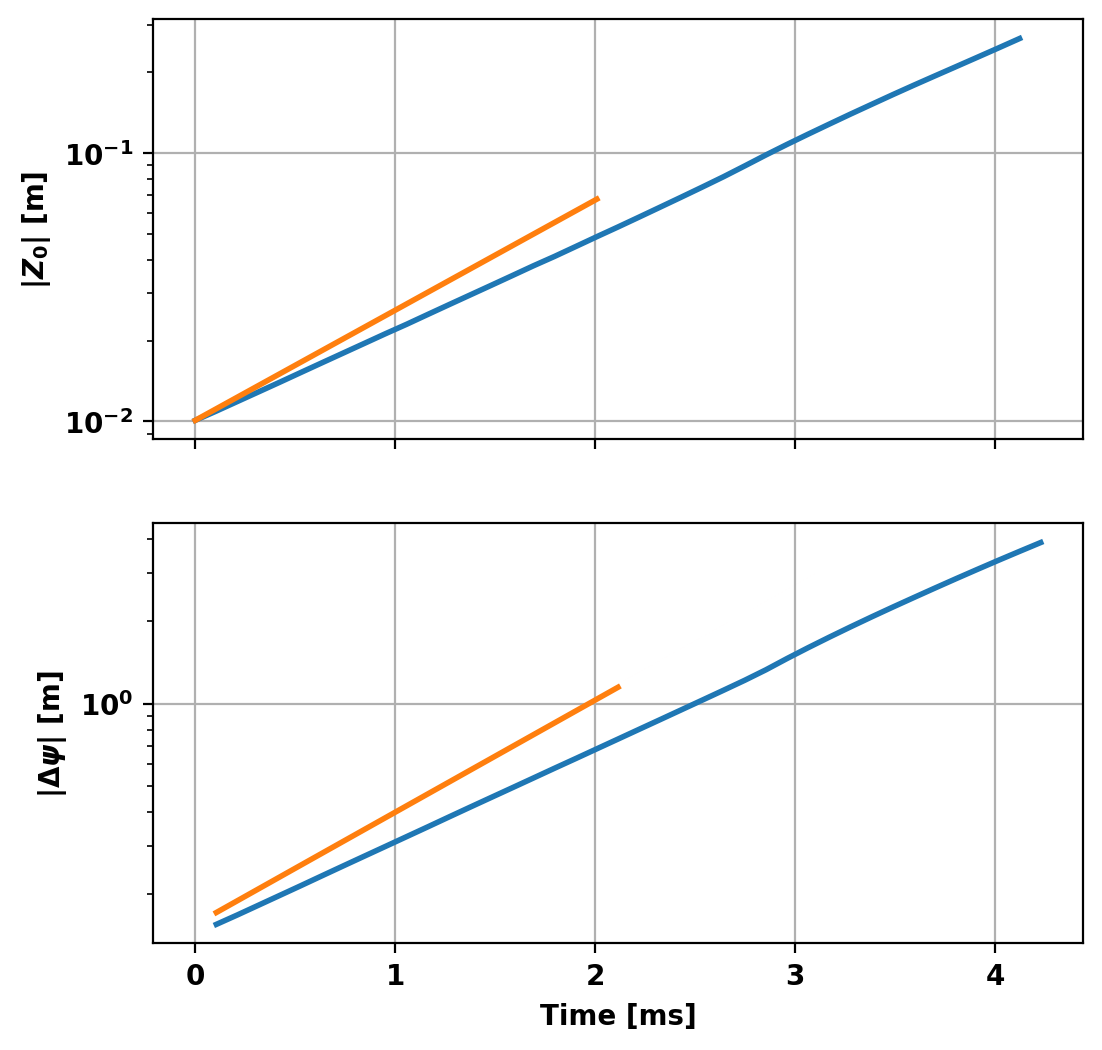

In [28]:
fig, ax = plt.subplots(2,1,sharex=True)
z_hist = np.asarray(z0); z_hist = z_hist[1:,:] - [z_hist[1,0], z_hist[0,1]]
ax[0].semilogy(z_hist[:,0]*1.E3,abs(z_hist[:,1]))
ax[0].semilogy(z_hist[:20,0]*1.E3,abs(z_hist[0,1])*np.exp(-z_hist[:20,0]*eig_vals[0,0]))
ax[0].set_ylabel(r'$|Z_0|$ [m]')
ax[0].grid(True)
eig_hist = np.asarray(eig_comp); eig_hist = eig_hist[1:,:]
ax[1].semilogy(eig_hist[:,0]*1.E3,abs(eig_hist[:,1]))
ax[1].semilogy(eig_hist[:20,0]*1.E3,abs(eig_hist[0,1])*np.exp(-eig_hist[:20,0]*eig_vals[0,0]))
ax[1].set_ylabel(r'$|\Delta \psi|$ [m]')
ax[1].grid(True)
_ = ax[-1].set_xlabel(r'Time [ms]')